In [2]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sns
import pandas as pd

import random
random.seed(42)

import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

In [3]:
image_size = (299, 299)
batch_size = 8
data_dir = '/home/fatah/Desktop/cnc'

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize(image_size)])

dataset = torchvision.datasets.ImageFolder(data_dir,
                                            transform=transform)


indices = np.arange(len(dataset))
train_indices, test_indices = train_test_split(indices, train_size= 8000*2, test_size= 2000*2, stratify= dataset.targets)

trainset = Subset(dataset, train_indices)
testset = Subset(dataset, test_indices)


train_data_loader = DataLoader(trainset,
                                                batch_size=batch_size,
                                                shuffle=True)

test_data_loader = DataLoader(testset,
                                                batch_size=batch_size,
                                                shuffle=False)

classes = ('chemical', 'nonchemical')

In [27]:
from collections import Counter
train_classes = [classes[dataset.targets[i]] for i in test_indices]
Counter(train_classes)

Counter({'nonchemical': 2000, 'chemical': 2000})

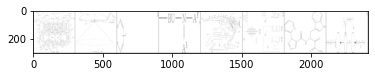

nonchemical nonchemical chemical chemical nonchemical nonchemical chemical chemical


In [28]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_data_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))


In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [30]:
model = torch.hub.load('pytorch/vision:v0.9.0', 'inception_v3', pretrained=False)
model.fc = nn.Linear(2048, 2)
model.to(device)

Using cache found in /home/fatah/.cache/torch/hub/pytorch_vision_v0.9.0
/home/fatah/anaconda3/envs/elsevier/lib/python3.8/site-packages/torchvision/models/inception.py:80: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn('The default weight initialization of inception_v3 will be changed in future releases of '


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [32]:
transform = transforms.Compose(
    [
     transforms.RandomHorizontalFlip(),
     transforms.RandomVerticalFlip(),
     transforms.RandomAdjustSharpness(0),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

epochs = 10

print(f"Starting model training for {epochs} epochs...")
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch+1}...")
    running_loss = 0.0
    for i, data in enumerate(train_data_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        inputs = transform(inputs)
#         # Zero the parameter gradients
        optimizer.zero_grad()
        
        outputs, aux = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:    # print every n mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
        running_loss = 0.0

PATH = './models/cnc_small.pth'
torch.save(model.state_dict(), PATH)


  0%|          | 0/10 [00:00<?, ?it/s]

Starting model training for 10 epochs...
Epoch: 1...
[1,   100] loss: 0.005
[1,   200] loss: 0.005
[1,   300] loss: 0.003
[1,   400] loss: 0.009
[1,   500] loss: 0.001
[1,   600] loss: 0.007
[1,   700] loss: 0.003
[1,   800] loss: 0.004
[1,   900] loss: 0.001
[1,  1000] loss: 0.001
[1,  1100] loss: 0.003
[1,  1200] loss: 0.000
[1,  1300] loss: 0.001
[1,  1400] loss: 0.009
[1,  1500] loss: 0.003
[1,  1600] loss: 0.003
[1,  1700] loss: 0.000
[1,  1800] loss: 0.000
[1,  1900] loss: 0.000



 10%|█         | 1/10 [08:02<1:12:18, 482.01s/it]

[1,  2000] loss: 0.000
Epoch: 2...
[2,   100] loss: 0.000
[2,   200] loss: 0.003
[2,   300] loss: 0.002
[2,   400] loss: 0.000
[2,   500] loss: 0.002
[2,   600] loss: 0.004
[2,   700] loss: 0.000
[2,   800] loss: 0.001
[2,   900] loss: 0.003
[2,  1000] loss: 0.007
[2,  1100] loss: 0.010
[2,  1200] loss: 0.003
[2,  1300] loss: 0.003
[2,  1400] loss: 0.001
[2,  1500] loss: 0.003
[2,  1600] loss: 0.001
[2,  1700] loss: 0.000
[2,  1800] loss: 0.009
[2,  1900] loss: 0.000



 20%|██        | 2/10 [16:01<1:04:04, 480.54s/it]

[2,  2000] loss: 0.002
Epoch: 3...
[3,   100] loss: 0.000
[3,   200] loss: 0.000
[3,   300] loss: 0.001
[3,   400] loss: 0.005
[3,   500] loss: 0.000
[3,   600] loss: 0.001
[3,   700] loss: 0.000
[3,   800] loss: 0.000
[3,   900] loss: 0.001
[3,  1000] loss: 0.000
[3,  1100] loss: 0.000
[3,  1200] loss: 0.002
[3,  1300] loss: 0.000
[3,  1400] loss: 0.001
[3,  1500] loss: 0.001
[3,  1600] loss: 0.000
[3,  1700] loss: 0.000
[3,  1800] loss: 0.000
[3,  1900] loss: 0.003



 30%|███       | 3/10 [24:02<56:04, 480.57s/it]  

[3,  2000] loss: 0.000
Epoch: 4...
[4,   100] loss: 0.002
[4,   200] loss: 0.002
[4,   300] loss: 0.000
[4,   400] loss: 0.000
[4,   500] loss: 0.000
[4,   600] loss: 0.000
[4,   700] loss: 0.004
[4,   800] loss: 0.000
[4,   900] loss: 0.002
[4,  1000] loss: 0.000
[4,  1100] loss: 0.000
[4,  1200] loss: 0.000
[4,  1300] loss: 0.001
[4,  1400] loss: 0.001
[4,  1500] loss: 0.000
[4,  1600] loss: 0.000
[4,  1700] loss: 0.006
[4,  1800] loss: 0.000
[4,  1900] loss: 0.000



 40%|████      | 4/10 [32:01<48:01, 480.17s/it]

[4,  2000] loss: 0.004
Epoch: 5...
[5,   100] loss: 0.001
[5,   200] loss: 0.003
[5,   300] loss: 0.003
[5,   400] loss: 0.000
[5,   500] loss: 0.001
[5,   600] loss: 0.000
[5,   700] loss: 0.000
[5,   800] loss: 0.000
[5,   900] loss: 0.000
[5,  1000] loss: 0.000
[5,  1100] loss: 0.000
[5,  1200] loss: 0.000
[5,  1300] loss: 0.000
[5,  1400] loss: 0.000
[5,  1500] loss: 0.012
[5,  1600] loss: 0.001
[5,  1700] loss: 0.001
[5,  1800] loss: 0.000
[5,  1900] loss: 0.000



 50%|█████     | 5/10 [40:06<40:08, 481.77s/it]

[5,  2000] loss: 0.000
Epoch: 6...
[6,   100] loss: 0.000
[6,   200] loss: 0.000
[6,   300] loss: 0.000
[6,   400] loss: 0.000
[6,   500] loss: 0.000
[6,   600] loss: 0.001
[6,   700] loss: 0.000
[6,   800] loss: 0.003
[6,   900] loss: 0.000
[6,  1000] loss: 0.001
[6,  1100] loss: 0.000
[6,  1200] loss: 0.000
[6,  1300] loss: 0.000
[6,  1400] loss: 0.000
[6,  1500] loss: 0.001
[6,  1600] loss: 0.000
[6,  1700] loss: 0.001
[6,  1800] loss: 0.000
[6,  1900] loss: 0.000



 60%|██████    | 6/10 [48:06<32:05, 481.26s/it]

[6,  2000] loss: 0.000
Epoch: 7...
[7,   100] loss: 0.006
[7,   200] loss: 0.000
[7,   300] loss: 0.003
[7,   400] loss: 0.002
[7,   500] loss: 0.000
[7,   600] loss: 0.000
[7,   700] loss: 0.000
[7,   800] loss: 0.000
[7,   900] loss: 0.000
[7,  1000] loss: 0.007
[7,  1100] loss: 0.001
[7,  1200] loss: 0.000
[7,  1300] loss: 0.002
[7,  1400] loss: 0.000
[7,  1500] loss: 0.002
[7,  1600] loss: 0.000
[7,  1700] loss: 0.000
[7,  1800] loss: 0.000
[7,  1900] loss: 0.001



 70%|███████   | 7/10 [56:07<24:03, 481.03s/it]

[7,  2000] loss: 0.000
Epoch: 8...
[8,   100] loss: 0.000
[8,   200] loss: 0.002
[8,   300] loss: 0.000
[8,   400] loss: 0.000
[8,   500] loss: 0.000
[8,   600] loss: 0.001
[8,   700] loss: 0.000
[8,   800] loss: 0.003
[8,   900] loss: 0.001
[8,  1000] loss: 0.000
[8,  1100] loss: 0.000
[8,  1200] loss: 0.000
[8,  1300] loss: 0.000
[8,  1400] loss: 0.000
[8,  1500] loss: 0.000
[8,  1600] loss: 0.002
[8,  1700] loss: 0.001
[8,  1800] loss: 0.000
[8,  1900] loss: 0.000



 80%|████████  | 8/10 [1:04:07<16:01, 480.94s/it]

[8,  2000] loss: 0.000
Epoch: 9...
[9,   100] loss: 0.000
[9,   200] loss: 0.001
[9,   300] loss: 0.001
[9,   400] loss: 0.001
[9,   500] loss: 0.001
[9,   600] loss: 0.000
[9,   700] loss: 0.000
[9,   800] loss: 0.000
[9,   900] loss: 0.000
[9,  1000] loss: 0.002
[9,  1100] loss: 0.000
[9,  1200] loss: 0.000
[9,  1300] loss: 0.000
[9,  1400] loss: 0.001
[9,  1500] loss: 0.000
[9,  1600] loss: 0.001
[9,  1700] loss: 0.003
[9,  1800] loss: 0.000
[9,  1900] loss: 0.000



 90%|█████████ | 9/10 [1:12:08<08:00, 480.99s/it]

[9,  2000] loss: 0.002
Epoch: 10...
[10,   100] loss: 0.000
[10,   200] loss: 0.000
[10,   300] loss: 0.000
[10,   400] loss: 0.002
[10,   500] loss: 0.000
[10,   600] loss: 0.000
[10,   700] loss: 0.000
[10,   800] loss: 0.000
[10,   900] loss: 0.000
[10,  1000] loss: 0.000
[10,  1100] loss: 0.000
[10,  1200] loss: 0.000
[10,  1300] loss: 0.000
[10,  1400] loss: 0.000
[10,  1500] loss: 0.000
[10,  1600] loss: 0.000
[10,  1700] loss: 0.000
[10,  1800] loss: 0.000
[10,  1900] loss: 0.000


100%|██████████| 10/10 [1:20:12<00:00, 481.21s/it]

[10,  2000] loss: 0.000


In [4]:
model = torch.hub.load('pytorch/vision:v0.9.0', 'inception_v3', pretrained=False)
model.fc = nn.Linear(2048, 2)
PATH = './models/cnc_small.pth'
model.load_state_dict(torch.load(PATH))
model.eval()

Using cache found in /home/fatah/.cache/torch/hub/pytorch_vision_v0.9.0
/home/fatah/anaconda3/envs/elsevier/lib/python3.8/site-packages/torchvision/models/inception.py:80: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn('The default weight initialization of inception_v3 will be changed in future releases of '


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [34]:
transform = transforms.Compose(
    [
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

outs = []
true_labels = []
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        images = transform(images)
        true_labels.extend(labels)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        outs.extend(predicted)
        c = (predicted == labels).squeeze()
        for i in range(batch_size):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(len(classes)):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

print(classification_report(true_labels, outs))

Accuracy of chemical : 94 %
Accuracy of nonchemical : 99 %
              precision    recall  f1-score   support

           0       1.00      0.94      0.97      2000
           1       0.94      1.00      0.97      2000

    accuracy                           0.97      4000
   macro avg       0.97      0.97      0.97      4000
weighted avg       0.97      0.97      0.97      4000



In [ ]:
df_cm = pd.DataFrame(confusion_matrix(true_labels, outs, normalize='true'), 
                      index = classes,
                      columns = classes)

plt.figure(figsize = (10,10))
sns.heatmap(df_cm, annot=True)

In [ ]:
dataiter = iter(test_data_loader)
images, labels = dataiter.next()

# print images
# imshow(torchvision.utils.make_grid(images, scale_each=True), )
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

f, axarr = plt.subplots(1, 8, figsize=(299,299))
for i, img in enumerate(images):
    axarr[i].imshow(img.permute(1, 2, 0).numpy())
    
_, predicted = torch.max(model(images), 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(batch_size)))

In [10]:
import os
from PIL import Image

image_size = (299, 299)
path = "/home/fatah/Desktop/EP_PNG"

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize(image_size),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

preds = {}

for img in sorted(os.listdir(path))[:500]:
    image = Image.open(os.path.join(path, img))
    image = image.convert('RGB')
    image = transform(image)
    with torch.no_grad():
        outputs = model(image[None, ...])
        aux,predicted = torch.max(outputs, 1)
        prediction = classes[predicted[0]]
        preds.setdefault(prediction, []).append(img)
        print(img,  prediction)
    

EP2947085A1_00082.PNG chemical
EP2947085A1_00083.PNG chemical
EP2947085A1_00084.PNG chemical
EP2947085A1_00085.PNG chemical
EP2947085A1_00086.PNG chemical
EP2947085A1_00087.PNG chemical
EP2947085A1_00088.PNG chemical
EP2947085A1_00089.PNG chemical
EP2947085A1_00090.PNG chemical
EP2947085A1_00091.PNG chemical
EP2947085A1_00092.PNG chemical
EP2947085A1_00093.PNG chemical
EP2947085A1_00094.PNG chemical
EP2947085A1_00095.PNG chemical
EP2947085A1_00096.PNG chemical
EP2947085A1_00097.PNG chemical
EP2947085A1_00098.PNG chemical
EP2947085A1_00099.PNG chemical
EP2947085A1_00100.PNG chemical
EP2947085A1_00101.PNG chemical
EP2947085A1_00102.PNG chemical
EP2947085A1_00103.PNG chemical
EP2947085A1_00104.PNG chemical
EP2947085A1_00105.PNG chemical
EP2947085A1_00106.PNG chemical
EP2947085A1_00107.PNG chemical
EP2947085A1_00108.PNG chemical
EP2947085A1_00109.PNG chemical
EP2947085A1_00110.PNG chemical
EP2947085A1_00111.PNG chemical
EP2947085A1_00112.PNG chemical
EP2947085A1_00113.PNG chemical
EP294708

EP2947093A1_00007.PNG nonchemical
EP2947093A1_00008.PNG nonchemical
EP2947093A1_00009.PNG nonchemical
EP2947093A1_00010.PNG nonchemical
EP2947093A1_00011.PNG nonchemical
EP2947093A1_00012.PNG nonchemical
EP2947093A1_00013.PNG nonchemical
EP2947093A1_00014.PNG nonchemical
EP2947093A1_00015.PNG nonchemical
EP2947093A1_00016.PNG nonchemical
EP2947093A1_00017.PNG nonchemical
EP2947093A1_00018.PNG nonchemical
EP2947093A1_00019.PNG nonchemical
EP2947093A1_00020.PNG nonchemical
EP2947093A1_00021.PNG nonchemical
EP2947093A1_00022.PNG nonchemical
EP2947093A1_00023.PNG nonchemical
EP2947093A1_00024.PNG nonchemical
EP2947093A1_00025.PNG nonchemical
EP2947093A1_00026.PNG nonchemical
EP2947093A1_00027.PNG nonchemical
EP2947093A1_00028.PNG nonchemical
EP2947093A1_00029.PNG nonchemical
EP2947093A1_00030.PNG nonchemical
EP2947093A1_00031.PNG nonchemical
EP2947093A1_00032.PNG nonchemical
EP2947093A1_00033.PNG nonchemical
EP2947093A1_00034.PNG nonchemical
EP2947093A1_00035.PNG nonchemical
EP2947093A1_00